<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Imports

In [1]:
import numpy as np
import pickle
import requests

# other imports go here

# Data loading and inspection

In [2]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

# Data augmentation and pipeline

unlabeled: (26000, 1, 32, 32)
labeled data: (2000, 1, 32, 32)
labeled labels: (2000, 5)
examples from labeled, repr1, repr2, unlabeled


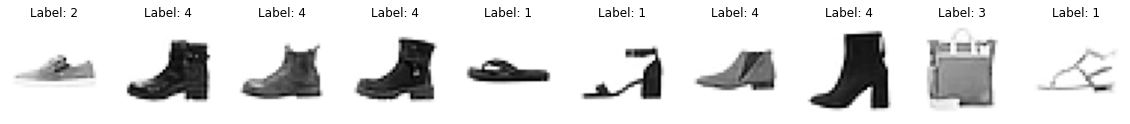

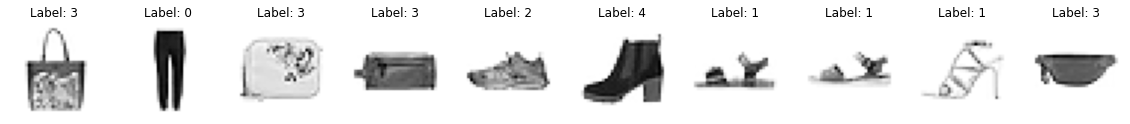

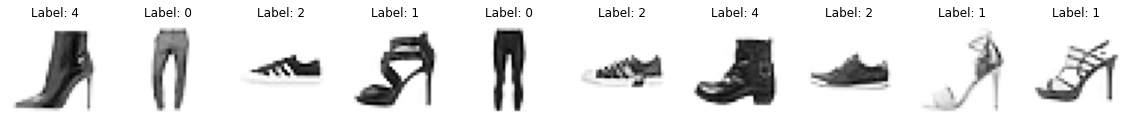

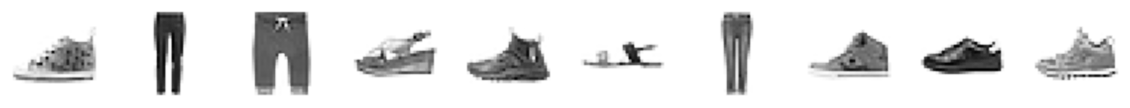

In [3]:
from torchvision.transforms.transforms import RandomRotation
# code for data augmentation pipeline 
print(f'unlabeled: {full_data["unlabeled_data"].shape}')
print(f'labeled data: {full_data["labeled_data"]["data"].shape}')
print(f'labeled labels: {full_data["labeled_data"]["labels"].shape}')

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

# augmentations
transform = transforms.Compose([
        transforms.ToTensor(),
])
transform2 = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation((0,45))
])

# augmentations = []

batch_size = 100

class UnlabeledDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.tensor(data)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx].numpy()).permute((1, 2, 0))
        return self.data[idx]


class LabeledDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.tensor(data['data'])
        self.labels = torch.tensor(data['labels'])
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx].numpy()).permute((1, 2, 0)), self.labels[idx]
        return self.data[idx], self.labels[idx]


def show_images(x, y=None, label_text='Label'):
    """ plots first ncols images in a batch """
    x = x.view(-1, 32, 32)
    ncols = x.shape[0]

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys")
        ax[idx].axis('off')
        if y is not None:
            ax[idx].set_title(f'{label_text}: {torch.nonzero(y[idx]).item()}')
    plt.show()

# training
unlabeled_ds = UnlabeledDataset(full_data['unlabeled_data'], transform=transform)
labeled_ds = LabeledDataset(full_data['labeled_data'], transform=transform)
repr_ds1 = LabeledDataset(full_data['representative_set_1'], transform=transform)
repr_ds2 = LabeledDataset(full_data['representative_set_2'], transform=transform)


unlabeled_ds_aug = UnlabeledDataset(full_data['unlabeled_data'], transform=transform2)
labeled_ds_aug = LabeledDataset(full_data['labeled_data'], transform=transform2)

print('examples from labeled, repr1, repr2, unlabeled')
for dl in [DataLoader(ds, batch_size=10, shuffle=True)
           for ds in [labeled_ds, repr_ds1, repr_ds2]]:
    for (x, y) in dl:
        show_images(x, y)
        break
for (x) in DataLoader(unlabeled_ds, batch_size=10, shuffle=True):
    show_images(x)
    break

# Model definitions

In [4]:
# code for model definitions goes here
# model goals:
# 1. detect out of distribution data
# 2. give low (10) dimensional description of dataset in terms of the 5 modes
# 3. classify remaining data points into the 5 classes

import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.fc_input = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear (hidden_dim, latent_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_input(x))
        h = torch.relu(self.fc_hidden(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.rand_like(sigma)
        z = mu + sigma * epsilon
        
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        x_reconstr = torch.sigmoid(self.fc_output(h))
        return x_reconstr


class Classifier(nn.Module):
    def __init__(self, latent_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Sequential(nn.Linear(hidden_dim, n_classes),nn.Softmax(dim=1))
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        h = torch.relu(self.fc_hidden3(h))
        out = self.fc_output(h)
        return out


class VAE(nn.Module):
    def __init__(self, encoder, decoder, classifier):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
            
    def forward(self, x):
        x = x.view(x.shape[0], encoder.input_dim)
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        y = self.classifier(z)

        return x_reconstr, mu, log_sigma, y

    def elbo_elementwise(self, x, x_reconstr, mu, log_sigma):
        reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
        constant_term = 32 * 32 * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
        kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
        elbo = - reconstr_loss - constant_term - kl_loss
        return elbo, reconstr_loss, kl_loss

    def predict(self, x, threshold_left, threshold_right):
        x = x.reshape(x.size()[0], -1)
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        elbo, reconstr_loss, kl_loss = self.elbo_elementwise(x, x_reconstr, mu, log_sigma)
        zero = torch.tensor([[0]])

        if reconstr_loss.item() > threshold_right or reconstr_loss.item() < threshold_left:
          y_pred = torch.tensor([[0,0,0,0,0,1]])
        else:
          y_pred = self.classifier(z)
          y_max = y_pred.argmax(1)
          y_pred = torch.zeros(y_pred.shape).scatter(1, y_max.unsqueeze (1), 1.0)
          y_pred = torch.cat((y_pred, zero), dim=1)
        return y_pred

    def evaluation(self, batch, batch_size, threshold_left, threshold_right):
        accuracy = 0
        abnormal = torch.tensor([[0,0,0,0,0,1]])
        abnormal_count = 0
        for idx in range(batch_size):
            x = batch[0][idx].unsqueeze(0)
            y = batch[1][idx]
            y_pred = self.predict(x, threshold_left, threshold_right)
            # print(y_pred, y)
            if torch.eq(y, y_pred).all(dim=1):
                # print(y, y_pred)
                if torch.eq(y, abnormal).all(dim=1):
                    abnormal_count += 1
                accuracy += 1
        return accuracy / batch_size, abnormal_count, accuracy

# Training and validation loop

In [5]:
# write your training and validation loop here

input_dim = 32*32
hidden_dim = 50
latent_dim = 10
n_classes = 5

encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=input_dim)
classifier = Classifier(latent_dim=latent_dim, hidden_dim=hidden_dim, n_classes=n_classes)

cuda = False

In [6]:
def loss_function(x, x_reconstr, mu, log_sigma, y=None, y_pred=None):
    classify_loss = 0
    reconstr_loss = nn.functional.mse_loss(x_reconstr.reshape(-1,1,32,32), x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)

    if y is not None and y_pred is not None:
        # TODO: add classification loss here (cross entropy)
        # TODO: should this also add some kind of divergence to push different classes away?????
        # criterion = nn.functional.cross_entropy()
        classify_loss = nn.functional.cross_entropy(y_pred,y)

    total_loss = reconstr_loss + kl_loss + classify_loss

    return total_loss, reconstr_loss, kl_loss, classify_loss

In [7]:
# Then, train on the unlabeled data
# perform training

epochs = 50

import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn

lr = 1e-3

def fit_unlabeled(model, dl):
    print("Start training VAE...")
    loss_graph = {'overall': [], 'reconstr': [], 'kl': []}
    

    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        # optimizer = optim.SGD(model.parameters(), lr=lr)
        overall_loss = 0
        overall_reconstr_loss = 0
        overall_kl_loss = 0
        n_datapoints = 0
        for x in dl:
            optimizer.zero_grad()

            # y is unused for unlabeled data
            x_reconstr, mu, log_sigma, _ = model(x)
            loss, reconstr_loss, kl_loss, _ = loss_function(x, x_reconstr, mu, log_sigma)
 
            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()
            
            loss.backward()
            optimizer.step()
            
            n_datapoints += x.shape[0]
        loss_graph['overall'].append(overall_loss / n_datapoints)
        loss_graph['reconstr'].append(overall_reconstr_loss / n_datapoints)
        loss_graph['kl'].append(overall_kl_loss / n_datapoints)

    print("Training complete!")
    return loss_graph


In [8]:
vae = VAE(encoder=encoder, decoder=decoder, classifier=classifier)
dl_dl = DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True)
graph_unlabel = fit_unlabeled(vae, dl_dl)

Start training VAE...


100%|██████████| 50/50 [00:55<00:00,  1.10s/it]

Training complete!


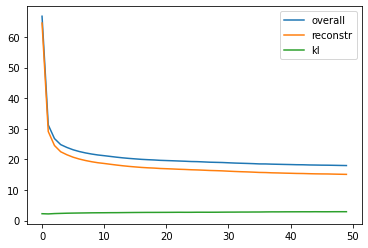

In [9]:
for label in ['overall', 'reconstr', 'kl']:
    plt.plot(np.arange(0, epochs), graph_unlabel[label], label=label)
plt.legend()
plt.show()


In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Encoder Model has {count_parameters(encoder)} parameters')
print(f'Decoder Model has {count_parameters(decoder)} parameters')
print(f'Classifier Model has {count_parameters(classifier)} parameters')
print(f'VAE Model has {count_parameters(vae)} parameters')

Encoder Model has 54820 parameters
Decoder Model has 55324 parameters
Classifier Model has 5905 parameters
VAE Model has 116049 parameters


In [11]:
vae_aug = VAE(encoder=encoder, decoder=decoder, classifier=classifier)
dl_dl_aug = DataLoader(unlabeled_ds_aug, batch_size=batch_size, shuffle=True)
graph_unlabel_aug = fit_unlabeled(vae_aug, dl_dl_aug)

Start training VAE...


100%|██████████| 50/50 [03:29<00:00,  4.18s/it]

Training complete!


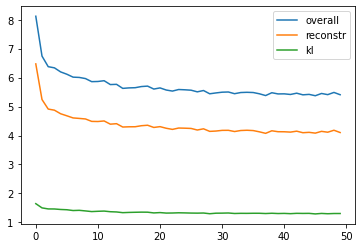

In [12]:
for label in ['overall', 'reconstr', 'kl']:
    plt.plot(np.arange(0, epochs), graph_unlabel_aug[label], label=label)
plt.legend()
plt.show()


torch.Size([10, 1, 32, 32])
torch.Size([10, 1024])


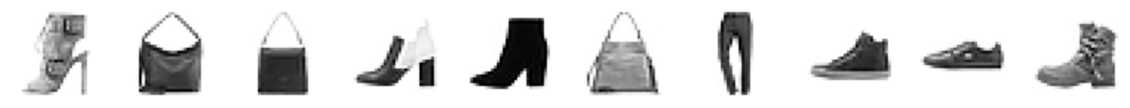

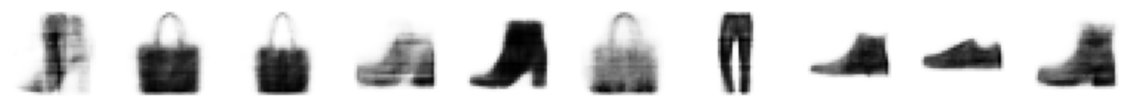

In [13]:
# Show some examples of vae-encoded images
for x in DataLoader(unlabeled_ds, batch_size=10, shuffle=True):
    with torch.no_grad():
        x_reconstr, _, _, _ = vae(x)
        print(x.shape)
        print(x_reconstr.shape)
        show_images(x)
        show_images(x_reconstr)
        break

In [14]:
from torch.optim import optimizer
# perform training

# Then, train on the labeled data
epochs = 150

import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional

lr = 1e-3

def classification_accuracy(model, dl):
    total = 0
    correct = 0
    with torch.no_grad():
        for x, y in dl:
            # only check against the non-anomalous samples
            idx = y[:, 5].squeeze() == 0
            x = x[idx]
            y = y[idx]
            _, _, _, y_pred = model(x)
            # one-hot encode y_pred
            max_yp = y_pred.argmax(1)
            y_pred = torch.zeros(y_pred.shape).scatter(1, max_yp.unsqueeze(1), 1.0)

            correct += sum(y.nonzero()[:, 1] == y_pred.nonzero()[:, 1])
            total += x.shape[0]

    return correct / total

def fit_labeled(model, dl, valid_dl):
    print("Start training VAE...")
    loss_graph = {'overall': [], 'reconstr': [], 'kl': [], 'classify': [], 'valid_acc': []}
    
    for epoch in tqdm(range(epochs)):
        model.train()
        #optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.9)
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        # optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.9), weight_decay=0.95
        overall_loss = 0
        overall_reconstr_loss = 0
        overall_kl_loss = 0
        overall_classify_loss = 0
        n_datapoints = 0
        for (x,y) in dl:
            optimizer.zero_grad()

            x_reconstr, mu, log_sigma, y_pred = model(x)

            loss, reconstr_loss, kl_loss, classify_loss = loss_function(x, x_reconstr, mu, log_sigma, y, y_pred)
 
            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()
            overall_classify_loss += classify_loss.item()
            
            loss.backward()
            optimizer.step()
            
            n_datapoints += x.shape[0]
        loss_graph['overall'].append(overall_loss / n_datapoints)
        loss_graph['reconstr'].append(overall_reconstr_loss / n_datapoints)
        loss_graph['kl'].append(overall_kl_loss / n_datapoints)
        loss_graph['classify'].append(overall_classify_loss / n_datapoints)
        loss_graph['valid_acc'].append(classification_accuracy(model, valid_dl))

    print("Training complete!")
    return loss_graph



In [15]:
valid_dl = DataLoader(repr_ds1, batch_size=batch_size)
graph_fit = fit_labeled(vae, DataLoader(labeled_ds, batch_size=batch_size, shuffle=True), valid_dl)

Start training VAE...


100%|██████████| 150/150 [00:19<00:00,  7.83it/s]

Training complete!


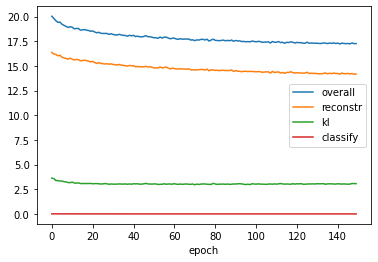

Text(0, 0.5, 'validation classification accuracy')

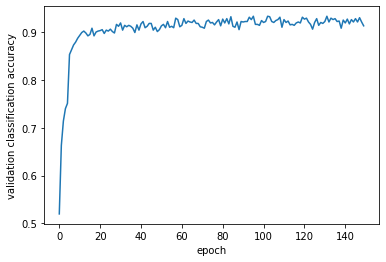

In [16]:
for label in ['overall', 'reconstr', 'kl', 'classify']:
    plt.plot(np.arange(0, epochs), graph_fit[label], label=label)
plt.legend()
plt.xlabel('epoch')
plt.show()

plt.plot(np.arange(0, epochs), graph_fit['valid_acc'])
plt.xlabel('epoch')
plt.ylabel('validation classification accuracy')

In [17]:
graph_fit_aug = fit_labeled(vae_aug, DataLoader(labeled_ds_aug, batch_size=batch_size, shuffle=True), valid_dl)

Start training VAE...


100%|██████████| 150/150 [00:57<00:00,  2.63it/s]

Training complete!


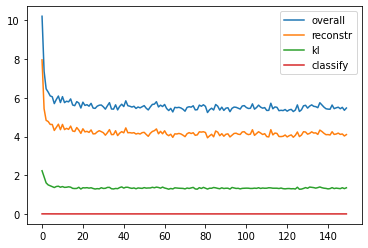

In [18]:
for label in ['overall', 'reconstr', 'kl', 'classify']:
    plt.plot(np.arange(0, epochs), graph_fit_aug[label], label=label)
plt.legend()
plt.show()

torch.Size([10, 1, 32, 32])
torch.Size([10, 1024])


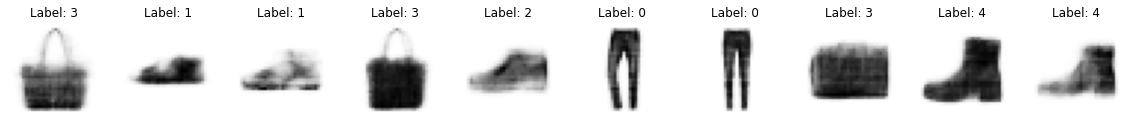

In [19]:
# Show examples of vae-encoded labeled images
for x, y in DataLoader(labeled_ds, batch_size=10, shuffle=True):
    with torch.no_grad():
        x_reconstr, _, _, y_pred = vae(x)
        print(x.shape)
        print(x_reconstr.shape)
        # one-hot encode y_pred
        max_yp = y_pred.argmax(1)
        y_pred = torch.zeros(y_pred.shape).scatter(1, max_yp.unsqueeze(1), 1.0)
        show_images(x_reconstr, y=y_pred)
        break

torch.Size([10, 1, 32, 32])
torch.Size([10, 1024])


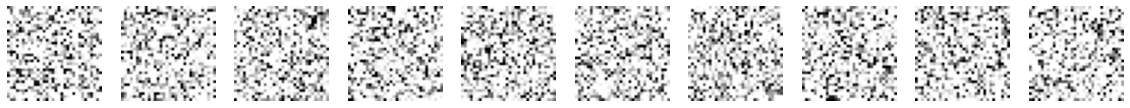

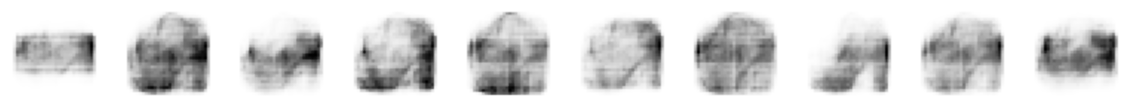

In [20]:
# What if we ask it to encode random images?
class RandomDataset(Dataset):
    def __init__(self, len, transform=None):
        self.transform = transform
        self.len = len

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # Create a random 32x32 image, the std. dev and mean were manually guestimated from some unlabeled images
        data = torch.clamp(torch.randn((1, 32, 32)) * 150 + 26, min=0, max=255).to(torch.uint8).numpy()
        if self.transform:
            return self.transform(data).permute((1, 2, 0))
        return data

random_ds = RandomDataset(len(repr_ds1), transform=transform)

for x in DataLoader(random_ds, batch_size=10, shuffle=True):
    with torch.no_grad():
        x_reconstr, _, _, _ = vae(x)
        print(x.shape)
        print(x_reconstr.shape)
        show_images(x)
        show_images(x_reconstr)
        break

# Inspection, Validation, and Analysis

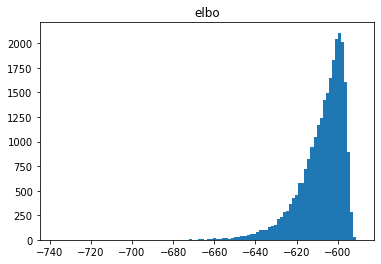

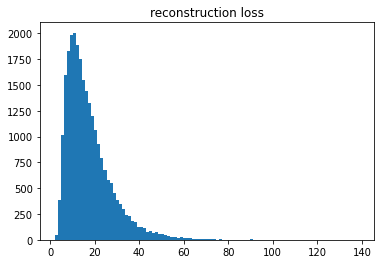

17.38701 10.43385 -3.4806900024414062 38.25471115112305


In [21]:
# Inspect, validate, and analyse your trained model
vae.eval()

normal_elbo = []
# anomaly_test_elbo = []
normal_rec = []
# anomaly_test_rec = []
batch_size = 1000

with torch.no_grad():
    for batch_idx, x in enumerate(unlabeled_ds):
        # print(x.size())
        x = x.reshape(x.shape[0], -1)
        x_rec, mu, log_sigma, _ = vae(x)

        x = x.view(x.size()[0], -1)
        elbo, rec, kl = vae.elbo_elementwise(x, x_rec, mu, log_sigma)
        normal_elbo.append(elbo.cpu().numpy())
        normal_rec.append(rec.cpu().numpy())
    
    normal_elbo = np.concatenate(normal_elbo, 0)
    normal_rec = np.concatenate(normal_rec, 0)

    plt.hist(normal_elbo, bins=100)
    plt.title('elbo')
    plt.show()
    plt.hist(normal_rec, bins=100)
    plt.title('reconstruction loss')
    plt.show()

    mu = np.mean(normal_rec)
    std = np.std(normal_rec)
    threshold_left = mu - 2*std
    threshold_right = mu + 2*std
    print(mu, std, threshold_left, threshold_right)


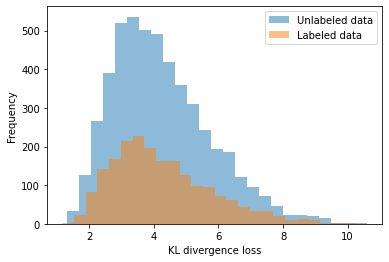

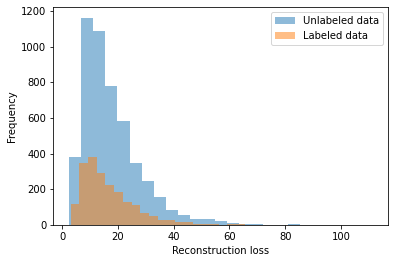

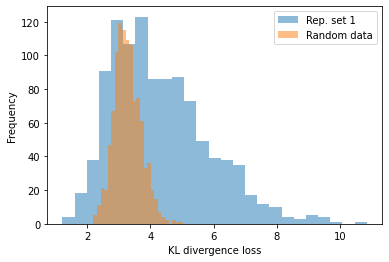

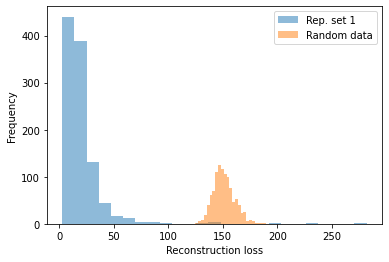

In [22]:
# Inspect, validate, and analyse your trained model

def loss_histogram(ds, model, lim=5000, kl_or_reconstr='kl', just_return=False):
    '''
    Show a histogram of kl divergence loss component for all values of dl
    if just_return, then don't show the plot, instead return the values.
    '''
    model = model.eval()
    loss_values = []
    # batch size 1 because we want to look at the loss of each individual image
    # since we don't look at too many images the loss of efficiency is not too bad
    for x in DataLoader(ds, batch_size=1, shuffle=False):
        if len(x) == 2:
            # in case it comes with labels, remove the labels
            x = x[0]
        with torch.no_grad():
            x_reconstr, mu, log_sigma, _ = model(x)
            _, reconstr_loss, kl_loss, _ = loss_function(x, x_reconstr, mu, log_sigma)
            loss_values.append(kl_loss if kl_or_reconstr=='kl' else reconstr_loss)
            if len(loss_values) >= lim:
                break
    
    if just_return:
        return loss_values
    plt.hist(loss_values, bins=25, alpha=0.5, label=label)
    plt.xlabel('KL divergence loss' if kl_or_reconstr=='kl' else 'Reconstruction loss')
    plt.ylabel('Frequency')

loss_histogram(unlabeled_ds, vae)
loss_histogram(labeled_ds, vae)
plt.legend(['Unlabeled data', 'Labeled data'])

plt.figure()
loss_histogram(unlabeled_ds, vae, kl_or_reconstr='reconstr')
loss_histogram(labeled_ds, vae, kl_or_reconstr='reconstr')
plt.legend(['Unlabeled data', 'Labeled data'])

plt.figure()
loss_histogram(repr_ds1, vae)
loss_histogram(random_ds, vae)
plt.legend(['Rep. set 1', 'Random data'])

plt.figure()
loss_histogram(repr_ds1, vae, kl_or_reconstr='reconstr')
loss_histogram(random_ds, vae, kl_or_reconstr='reconstr')
plt.legend(['Rep. set 1', 'Random data'])

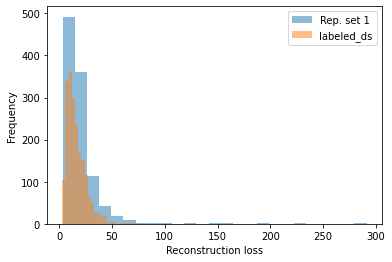

In [23]:
plt.figure()
loss_histogram(repr_ds1, vae, kl_or_reconstr='reconstr')
loss_histogram(labeled_ds, vae, kl_or_reconstr='reconstr')
plt.legend(['Rep. set 1', 'labeled_ds'])

In [24]:
# perform testing
mu1, mu2, mu3, mu4, mu5, mu_out = list(), list(), list(), list(), list(), list()
s1, s2, s3, s4, s5, s_out = list(), list(), list(), list(), list(), list()

def test_labeled(model, dl):
    print("Start testing VAE...")
    loss_graph = {'overall': [], 'reconstr': [], 'kl': [], 'classify': []}
    
    model.eval()
    with torch.no_grad():
        for (x,y) in dl:
            x_reconstr, mu, log_sigma, y_pred = model(x)
            
            for i in range(x.shape[0]):
                if y[i][0] == 1:
                    mu1.append(mu[i][0])
                    s1.append(log_sigma[i][0])
                elif y[i][1] == 1:
                    mu2.append(mu[i][0])
                    s2.append(log_sigma[i][0])
                elif y[i][2] == 1:
                    mu3.append(mu[i][0])
                    s3.append(log_sigma[i][0])
                elif y[i][3] == 1:
                    mu4.append(mu[i][0])
                    s4.append(log_sigma[i][0])
                elif y[i][4] == 1:
                    mu5.append(mu[i][0])
                    s5.append(log_sigma[i][0])
                elif y[i][5] == 1:
                    mu_out.append(mu[i][0])
                    s_out.append(log_sigma[i][0])
   

    return loss_graph

graph = test_labeled(vae, DataLoader(repr_ds1, batch_size=batch_size, shuffle=True))

Start testing VAE...


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu_mu1 = np.mean(mu1)
mu_mu2 = np.mean(mu2)
mu_mu3 = np.mean(mu3)
mu_mu4 = np.mean(mu4)
mu_mu5 = np.mean(mu5)
mu_mu_out = np.mean(mu_out)

s_s1 = np.sqrt(sum([x**2 for x in s1])/len(s1))
s_s2 = np.sqrt(sum([x**2 for x in s2])/len(s2))
s_s3 = np.sqrt(sum([x**2 for x in s3])/len(s3))
s_s4 = np.sqrt(sum([x**2 for x in s4])/len(s4))
s_s5 = np.sqrt(sum([x**2 for x in s5])/len(s5))
s_s_out = np.sqrt(sum([x**2 for x in s_out])/len(s_out))

mu = np.mean([mu_mu1, mu_mu2, mu_mu3, mu_mu4, mu_mu5, mu_mu_out])
sigma = np.sqrt(sum([s_s1**2, s_s2**2, s_s3**2, s_s4**2, s_s5**2, s_s_out**2]))

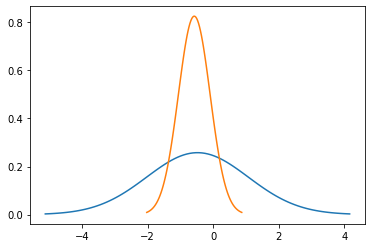

In [26]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_1 = np.linspace(mu_mu1 - 3*s_s1, mu_mu1 + 3*s_s1, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_1, stats.norm.pdf(x_1, mu_mu1, s_s1))
plt.show()

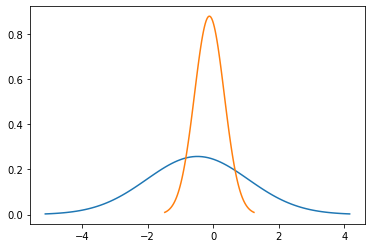

In [27]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_2 = np.linspace(mu_mu2 - 3*s_s2, mu_mu2 + 3*s_s2, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_2, stats.norm.pdf(x_2, mu_mu2, s_s2))
plt.show()

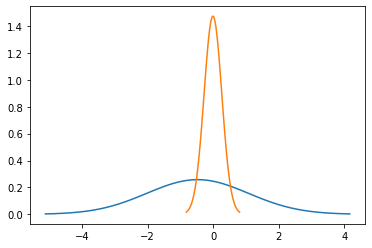

In [28]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_3 = np.linspace(mu_mu3 - 3*s_s3, mu_mu3 + 3*s_s3, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_3, stats.norm.pdf(x_3, mu_mu3, s_s3))
plt.show()

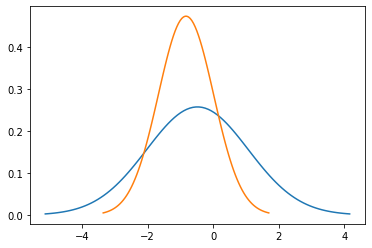

In [29]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_4 = np.linspace(mu_mu4 - 3*s_s4, mu_mu4 + 3*s_s4, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_4, stats.norm.pdf(x_4, mu_mu4, s_s4))
plt.show()

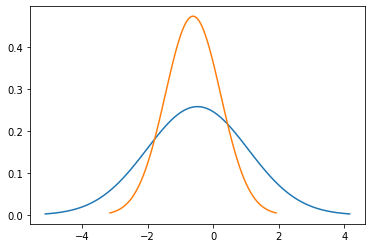

In [30]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_5 = np.linspace(mu_mu5 - 3*s_s5, mu_mu5 + 3*s_s5, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_5, stats.norm.pdf(x_5, mu_mu5, s_s5))
plt.show()

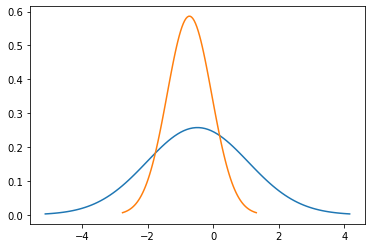

In [31]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x_out = np.linspace(mu_mu_out - 3*s_s_out, mu_mu_out + 3*s_s_out, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(x_out, stats.norm.pdf(x_out, mu_mu_out, s_s_out))
plt.show()

100%|██████████| 101/101 [00:29<00:00,  3.47it/s]

closest to (0, 1) is 42.40678100585938
tp = 0.5961538461538461 and fp = 0.026


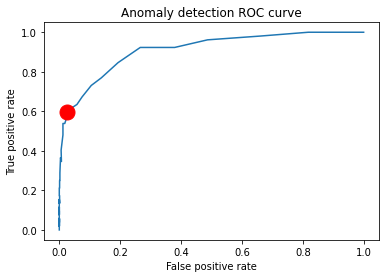

In [32]:
# Our model does anomaly detection based on the reconstruction loss.
# To tune the anomaly threshold, we will see the ROC curve on the validation set.

threshold_max = max(loss_histogram(repr_ds1, vae, kl_or_reconstr='reconstr', just_return=True))

def evaluate_roc(model, labeled_ds, threshold):
    '''Given the model and threshold, return (tpr, fpr) on the given dataset for anomaly detection'''
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    losses = loss_histogram(labeled_ds, model, kl_or_reconstr='reconstr', just_return=True)
    pred_anomaly = [loss >= threshold for loss in losses]
    for idx, (_, y) in enumerate(DataLoader(labeled_ds, batch_size=1, shuffle=False)):
        # squeeze batch size dimension since it is 1
        y = y.squeeze(0)
        if pred_anomaly[idx] and y[5] == 1:
            tp += 1
        elif pred_anomaly[idx] and y[5] == 0:
            fp += 1
        elif not pred_anomaly[idx] and y[5] == 1:
            fn += 1
        elif not pred_anomaly[idx] and y[5] == 0:
            tn += 1
    return tp / (tp + fn), fp / (fp + tn)

# evaluate at 1-percent increments from 0 to threshold max
threshold_space = np.linspace(0, 100, 101) * (threshold_max.item() / 100)
roc_curve = [evaluate_roc(vae, repr_ds1, t) for t in tqdm(threshold_space)]
roc_x = [fp for _, fp in roc_curve]
roc_y = [tp for tp, _ in roc_curve]
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Anomaly detection ROC curve')
plt.plot(roc_x, roc_y)
# Best threshold is the one closest to (0, 1). We'll take euclidean distance.
# But in this case, it is more important that we minimize false positive rate.
# That is because the representative dataset has very few anomalies, so if we tuned the threshold
# to be too loose (i.e. too small), then we misclassify many samples that should be left alone.
# The fpr weight of 6 here is based on the number of classes in the data.
best_idx = min(range(len(threshold_space)), key=lambda idx: (6 * roc_x[idx])**2 + (1 - roc_y[idx])**2)
best_threshold = threshold_space[best_idx]
plt.plot([roc_x[best_idx]], [roc_y[best_idx]], 'or', markersize=15)
print(f'closest to (0, 1) is {best_threshold}')
print(f'tp = {roc_y[best_idx]} and fp = {roc_x[best_idx]}')

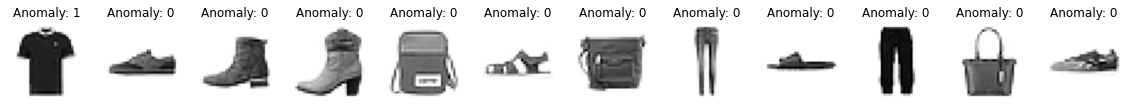

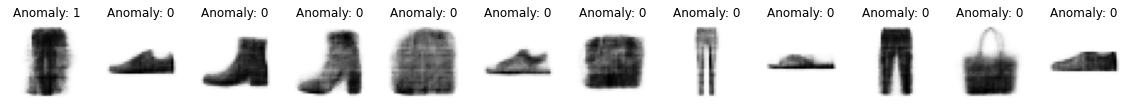

In [33]:
# Let's look at some anomaly classifications under our best threshold
vae = vae.eval()
for x, y in DataLoader(repr_ds1, batch_size=12, shuffle=True):
    with torch.no_grad():
        x_reconstr, _, _, _ = vae(x)
        # no reduction gets us the value for each pixel, then we sum over each image
        reconstr_losses = torch.sum(
            nn.functional.mse_loss(x_reconstr.reshape(-1,1,32,32), x, reduction='none').reshape(-1, 32*32),
            dim=1
        )
        # re-encode y and y_pred as one-hot of [normal, anomaly] classification
        y_pred = torch.tensor(
            np.stack([[0, 1] if is_anomaly else [1, 0] for is_anomaly in reconstr_losses > best_threshold])
        )
        y_true = torch.tensor(
            np.stack([[0, 1] if is_anomaly else [1, 0] for is_anomaly in y[:, 5] == 1])
        )
        # uncomment to see mistakes: indices where y_pred and y_true do not match
        # m_idx = (y_pred - y_true).max(dim=1)[1].nonzero().squeeze(1)
        m_idx = torch.tensor(np.arange(x.shape[0]))
        show_images(x[m_idx][:12], y=y_true[m_idx][:12], label_text='Anomaly')
        show_images(x_reconstr[m_idx][:12], y=y_pred[m_idx][:12], label_text='Anomaly')
    break

In [43]:
# Great, now let's get the overall classification accuracy on the validation and test sets
def test_accuracy(ds, model, threshold):
    model = model.eval()
    total_correct = 0
    total_seen = 0
    for x, y in DataLoader(ds, batch_size=1, shuffle=True):
        with torch.no_grad():
            x_reconstr, _, _, y_pred = model(x)
            # no reduction gets us the value for each pixel, then we sum over each image
            reconstr_losses = torch.sum(
                nn.functional.mse_loss(x_reconstr.reshape(-1,1,32,32), x, reduction='none').reshape(-1, 32*32),
                dim=1
            )
            # one-hot encode y_pred
            max_yp = y_pred.argmax(1)
            y_pred = torch.zeros(y_pred.shape).scatter(1, max_yp.unsqueeze(1), 1.0)
            # y_pred has 5 columns, add another one to indicate whether it is anomalous
            y_pred = torch.hstack([y_pred, torch.zeros(y_pred.shape[0], 1)])
            # if the item is anomalous, then set the prediction to the anomaly value
            anomalous_pred = (reconstr_losses > threshold).nonzero().squeeze(0)
            y_pred[anomalous_pred, :5] = 0
            y_pred[anomalous_pred, 5] = 1
            # count the number of ones that are in the same place
            total_correct += (y.nonzero()[:, 1] == y_pred.nonzero()[:, 1]).sum()
            total_seen += x.shape[0]
    return (total_correct / total_seen).item()

print(f'Accuracy on validation set is {test_accuracy(repr_ds1, vae, best_threshold)}')
print(f'Accuracy on test set is {test_accuracy(repr_ds2, vae, best_threshold)}')

Accuracy on validation set is 0.8488593101501465
Accuracy on test set is 0.8545627593994141
